In [26]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

from pymc_extras.statespace.core.statespace import PyMCStateSpace
import pytensor.tensor as pt
import pymc as pm

In [27]:
matrix_names = [
    "initial_state",
    "initial_state_cov",
    "state_intercept",
    "obs_intercept",
    "transition",
    "design",
    "selection",
    "obs_cov",
    "state_cov",
]


def print_model_ssm(mod, how="eval"):
    nice_heading = f'{"name":<20}{"__repr__":<50}{"shape":<10}{"value":<20}'
    print(nice_heading)
    print("=" * len(nice_heading))
    if how == "eval":
        matrices = [x.eval() for x in mod._unpack_statespace_with_placeholders()]
    elif how == "draw":
        matrices = pm.draw(mod.unpack_statespace())

    for name, value in zip(matrix_names, matrices):
        repr_ = str(mod.ssm[name])
        shape = str(mod.ssm[name].type.shape)
        value = str(value).replace("\n ", "\n" + " " * 81)
        print(f"{name:<20}{repr_:<50}{shape:<10}{value:<20}")
        print("-" * len(nice_heading))

In [28]:
seed = sum(map(ord, "custom statespace model"))
rng = np.random.default_rng(seed)


# Dynamic Factor Model (DFM) 

A Dynamic Factor Model represents a system where multiple observed time series are driven by a smaller number of unobserved common factors. Here's how to formulate a DFM with **2 observed variables**, **1 latent factor**, and 1 innovation shock in state space form.

State Space Representation

The state space representation consists of a observation equation and a transition equation:

$$\begin{align} f_{t} &= A f_{t-1} + \varepsilon_t, & \varepsilon_t &\sim N(0, \sigma^2_{\text{factor}}) \\ y_t &= \Lambda f_t + \eta_t, & \eta_t &\sim N(0, H) \\ x_0 &\sim N(\bar{x}_0, P_0) \end{align}$$


**Where:**

**Transition Equation**
- $f_t$ is a scalar representing the single latent factor at time $t$
- $A$ is the autoregressive coefficient for the factor (capturing persistence)
- $\varepsilon_t$ is the innovation to the factor with variance $\sigma^2_{\text{factor}}$

**Observation Equation**
- $y_t = \begin{bmatrix} y_{1t} \\ y_{2t} \end{bmatrix}$ is a $2 \times 1$ vector of observed variables
- $\Lambda = \begin{bmatrix} \lambda_1 \\ \lambda_2 \end{bmatrix}$ is a $2 \times 1$ vector of factor loadings
- $\eta_t = \begin{bmatrix} \eta_{1t} \\ \eta_{2t} \end{bmatrix}$ is a $2 \times 1$ vector of observation errors
- $H = \begin{bmatrix} \sigma^2_{1} & 0 \\ 0 & \sigma^2_{2} \end{bmatrix}$ is the diagonal covariance matrix of observation errors

In this example the error term of the observation variable is not assumed to be autoregressive

**Initial State**
- $\bar{x}_0$ is the initial factor mean (typically set to 0)
- $P_0$ is the initial factor variance (typically set to a large value to represent uncertainty)

** State Space representation for PyMC model
$$\begin{align} \begin{bmatrix} f_t \\ f_{t-1} \end{bmatrix} &= \begin{bmatrix} A & 0 \\ 1 & 0 \end{bmatrix} \begin{bmatrix} f_{t-1} \\ f_{t-2} \end{bmatrix} + \begin{bmatrix} 1 \\ 0  \end{bmatrix} \varepsilon_t, & \varepsilon_t &\sim N \left (0, \begin{bmatrix}\sigma^2_x\end{bmatrix} \right) \\
 y_t &= \begin{bmatrix} \lambda_1 \\ \lambda_2 \end{bmatrix} \begin{bmatrix}f_t  \end{bmatrix} \end{align}$$
 

### Parameters
The model has 4 key parameters:  

- A : autoregresive coefficient for the latent factor
- $\lambda_1, \lambda_2$ : the factor loadings  
- $\sigma^2_{\text{factor}}$ : the factor innovation variance  







### The `__init__` method

In [29]:
class DFM_dummy(PyMCStateSpace):
    def __init__(self):
        k_states = 1  # size of the state vector x
        k_posdef = 1  # number of shocks (size of the state covariance matrix Q)
        k_endog = 2  # number of observed states

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef)

    def make_symbolic_graph(self):
        # We will implement this in a moment. For now, we need to overwrite it with nothing to avoid a NotImplementedError
        # when we initialize a class instance.
        pass

In [30]:
dfm = DFM_dummy()

In [31]:
print_model_ssm(dfm)

name                __repr__                                          shape     value               
initial_state       initial_state{[0.]}                               (1,)      [0.]                
----------------------------------------------------------------------------------------------------
initial_state_cov   initial_state_cov{[[0.]]}                         (1, 1)    [[0.]]              
----------------------------------------------------------------------------------------------------
state_intercept     state_intercept                                   (1,)      [0.]                
----------------------------------------------------------------------------------------------------
obs_intercept       obs_intercept                                     (2,)      [0. 0.]             
----------------------------------------------------------------------------------------------------
transition          transition                                        (1, 1)    [[0.]]     

In [32]:
dfm.ssm["design", :, :] = np.array([[0.0], [0.0]])
dfm.ssm["transition", :, :] = np.array([0.0])
dfm.ssm["selection", :, :] = np.array([[1.0]])

In [33]:
print_model_ssm(dfm)

name                __repr__                                          shape     value               
initial_state       initial_state{[0.]}                               (1,)      [0.]                
----------------------------------------------------------------------------------------------------
initial_state_cov   initial_state_cov{[[0.]]}                         (1, 1)    [[0.]]              
----------------------------------------------------------------------------------------------------
state_intercept     state_intercept                                   (1,)      [0.]                
----------------------------------------------------------------------------------------------------
obs_intercept       obs_intercept                                     (2,)      [0. 0.]             
----------------------------------------------------------------------------------------------------
transition          transition                                        (1, 1)    [[0.]]     

In [34]:
class DFM_dummy(PyMCStateSpace):
    def __init__(self):
        k_states = 1  # size of the state vector x
        k_posdef = 1  # number of shocks (size of the state covariance matrix Q)
        k_endog = 2  # number of observed states

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef)

    def make_symbolic_graph(self):
        # We will implement this in a moment. For now, we need to overwrite it with nothing to avoid a NotImplementedError
        # when we initialize a class instance.
        dfm.ssm["design", :, :] = np.array([[0.0], [0.0]])
        dfm.ssm["transition", :, :] = np.array([0.0])
        dfm.ssm["selection", :, :] = np.array([[1.0]])

In [35]:
dfm = DFM_dummy()
print_model_ssm(dfm)

name                __repr__                                          shape     value               
initial_state       initial_state{[0.]}                               (1,)      [0.]                
----------------------------------------------------------------------------------------------------
initial_state_cov   initial_state_cov{[[0.]]}                         (1, 1)    [[0.]]              
----------------------------------------------------------------------------------------------------
state_intercept     state_intercept                                   (1,)      [0.]                
----------------------------------------------------------------------------------------------------
obs_intercept       obs_intercept                                     (2,)      [0. 0.]             
----------------------------------------------------------------------------------------------------
transition          transition                                        (1, 1)    [[0.]]     

In [36]:
class DFM_dummy(PyMCStateSpace):
    def __init__(self):
        k_states = 1  # size of the state vector x
        k_posdef = 1  # number of shocks (size of the state covariance matrix Q)
        k_endog = 2  # number of observed states

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef)

    def make_symbolic_graph(self):
        # Create symbolic variables for 1D state
        x0 = self.make_and_register_variable("f0", shape=(1,))
        P0 = self.make_and_register_variable("P0", shape=(1, 1))
        lambda_1 = self.make_and_register_variable("lambda_1", shape=())
        lambda_2 = self.make_and_register_variable("lambda_2", shape=())
        a = self.make_and_register_variable("a", shape=())
        sigma_x = self.make_and_register_variable("sigma_f", shape=())

        # Initialize matrices with correct dimensions
        self.ssm["design", :, :] = np.array([[0.0], [0.0]])  # 2x1 matrix
        self.ssm["transition", :, :] = np.array([[0.0]])  # 1x1 matrix
        self.ssm["selection", :, :] = np.array([[1.0]])  # 1x1 matrix

        # Set initial state and covariance
        self.ssm["initial_state", :] = x0
        self.ssm["initial_state_cov", :, :] = P0

        # Set design matrix parameters
        self.ssm["design", 0, 0] = lambda_1  # First observation loading
        self.ssm["design", 1, 0] = lambda_2  # Second observation loading

        # Set transition parameter (AR coefficient)
        self.ssm["transition", 0, 0] = a

        # Set state covariance
        self.ssm["state_cov", 0, 0] = sigma_x

    @property
    def param_names(self):
        return ["f0", "P0", "a", "sigma_f", "lambda_1", "lambda_2"]

In [37]:
dfm = DFM_dummy()
dfm._name_to_variable

{'f0': f0,
 'P0': P0,
 'lambda_1': lambda_1,
 'lambda_2': lambda_2,
 'a': a,
 'sigma_f': sigma_f}

In [38]:
dfm = DFM_dummy()
data = np.full((100, 2), np.nan)
with pm.Model() as pymc_mod:
    x0 = pm.Deterministic(
        "f0",
        pt.zeros(1),
    )
    P0 = pm.Deterministic("P0", pt.eye(1))
    lambda_1 = pm.Normal("lambda_1", sigma=0.25, shape=())
    lambda_2 = pm.Normal("lambda_2", sigma=0.25, shape=())
    a = pm.Normal("a", sigma=0.25, shape=())
    sigma_x = pm.Exponential("sigma_f", 1)

    dfm.build_statespace_graph(data=data, mode="JAX")

/Users/andrea/Desktop/gitProject/pymc-extras/pymc_extras/statespace/utils/data_tools.py:174: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)


In [39]:
matrices = dfm.unpack_statespace()
len(matrices)

9

In [40]:
print_model_ssm(dfm, "draw")

name                __repr__                                          shape     value               
initial_state       initial_state                                     (1,)      [0.]                
----------------------------------------------------------------------------------------------------
initial_state_cov   initial_state_cov                                 (1, 1)    [[1.]]              
----------------------------------------------------------------------------------------------------
state_intercept     state_intercept                                   (1,)      [0.]                
----------------------------------------------------------------------------------------------------
obs_intercept       obs_intercept                                     (2,)      [0. 0.]             
----------------------------------------------------------------------------------------------------
transition          transition                                        (1, 1)    [[0.5751899

In [41]:
with pymc_mod:
    prior = pm.sample_prior_predictive(compile_kwargs={"mode": "JAX"}, random_seed=rng)

/opt/anaconda3/envs/pymc_extras_env/lib/python3.10/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x16A6120A0>), RNG(<Generator(PCG64) at 0x16A611D20>), RNG(<Generator(PCG64) at 0x16A611EE0>), RNG(<Generator(PCG64) at 0x16D139E00>), RNG(<Generator(PCG64) at 0x16A612260>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
/opt/anaconda3/envs/pymc_extras_env/lib/python3.10/functools.py:889: UserWarning: Skipping `CheckAndRaise` Op (assertion: PyTensor Assert failed!) as JAX tracing would remove it.
  return dispatch(args[0].__class__)(*args, **kw)
Sampling: [a, lambda_1, lambda_2, obs, sigma_f]


In [42]:
uncond_prior = dfm.sample_unconditional_prior(prior, steps=100, random_seed=rng)
prior_obs = uncond_prior.prior_observed.stack(sample=["chain", "draw"])

# Take only the non-explosive samples
stationary_samples = prior_obs.isel(
    sample=(np.abs(prior_obs).max(dim=["prior_observed_dim_0"]) < 10).values[0]
)

/opt/anaconda3/envs/pymc_extras_env/lib/python3.10/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x319002500>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [prior_combined]


Output()

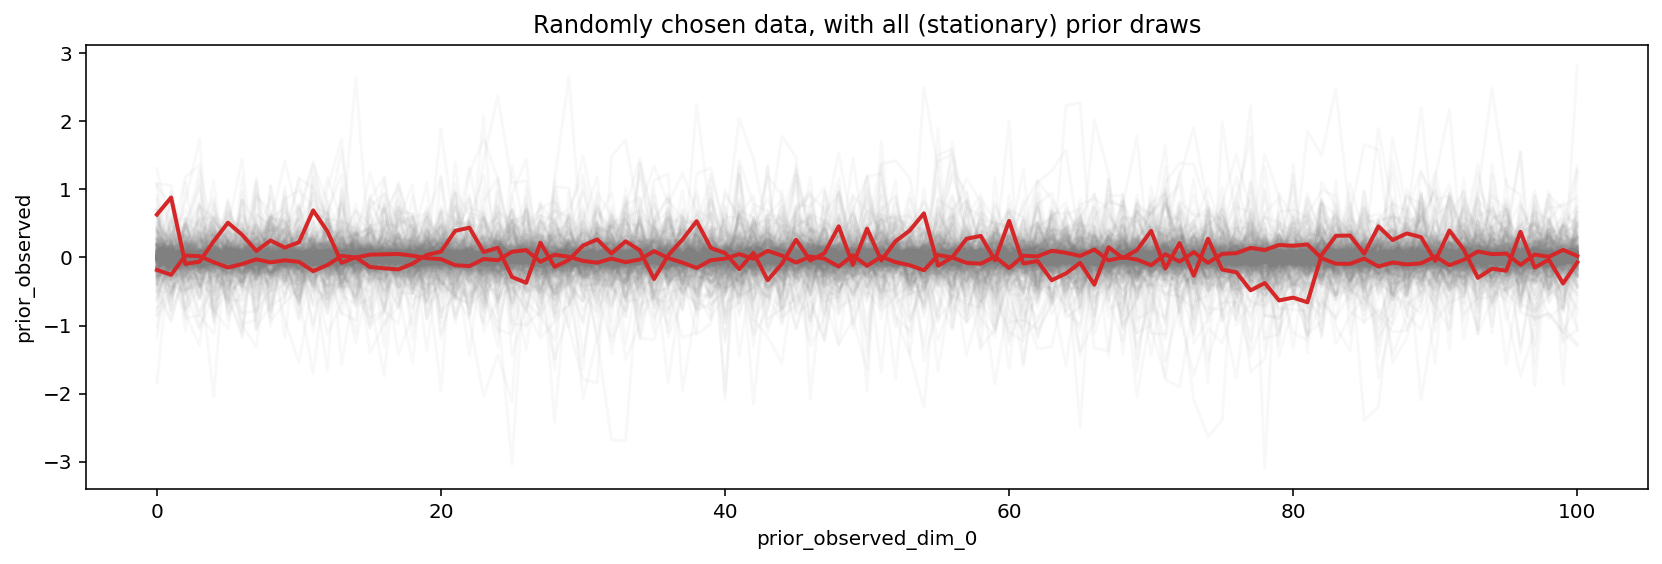

In [43]:
# Choose a sample to model at random from the non-explosive ones
data_idx = rng.choice(stationary_samples.coords["sample"].draw.values)
data = stationary_samples.sel(chain=0, draw=data_idx).values

fig, ax = plt.subplots(figsize=(14, 4), dpi=144)
(
    stationary_samples.sel(prior_observed_dim_1=0).plot.line(
        x="prior_observed_dim_0", add_legend=False, ax=ax, color="0.5", alpha=0.05
    )
)
ax.plot(data, color="tab:red", lw=2)
ax.set_title("Randomly chosen data, with all (stationary) prior draws")
plt.show()

In [44]:
# Save the true parameters and sigma_x to see how well we do recovering them
true_lambda_1 = prior.prior.lambda_1.sel(chain=0, draw=data_idx).values
true_lambda_2 = prior.prior.lambda_2.sel(chain=0, draw=data_idx).values
true_a = prior.prior.a.sel(chain=0, draw=data_idx).values
true_sigma_f = prior.prior.sigma_f.sel(chain=0, draw=data_idx).values

In [45]:
dfm = DFM_dummy()

with pm.Model() as pymc_mod:
    # Define model parameters
    x0 = pm.Deterministic(
        "f0",
        pt.zeros(1),
    )
    P0 = pm.Deterministic("P0", pt.eye(1))
    lambda_1 = pm.Normal("lambda_1", sigma=1, shape=())
    lambda_2 = pm.Normal("lambda_2", sigma=1, shape=())
    a = pm.Normal("a", sigma=1, shape=())
    sigma_x = pm.HalfNormal("sigma_f", sigma=1)

    idata = pm.sample(
        draws=1000,
        chains=2,
        nuts_sampler="nutpie",
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.82,3
,2000,1,0.74,7


<Axes: >

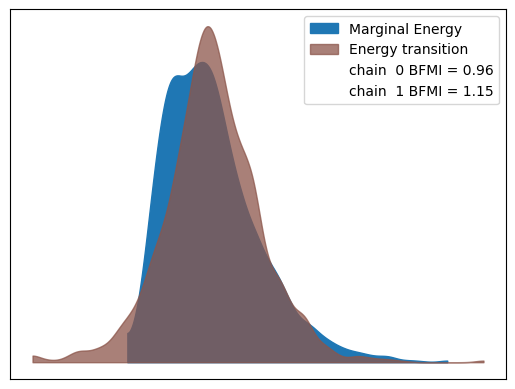

In [46]:
az.plot_energy(idata)

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'lambda_1'}>,
        <Axes: title={'center': 'lambda_1'}>],
       [<Axes: title={'center': 'lambda_2'}>,
        <Axes: title={'center': 'lambda_2'}>],
       [<Axes: title={'center': 'sigma_f'}>,
        <Axes: title={'center': 'sigma_f'}>]], dtype=object)

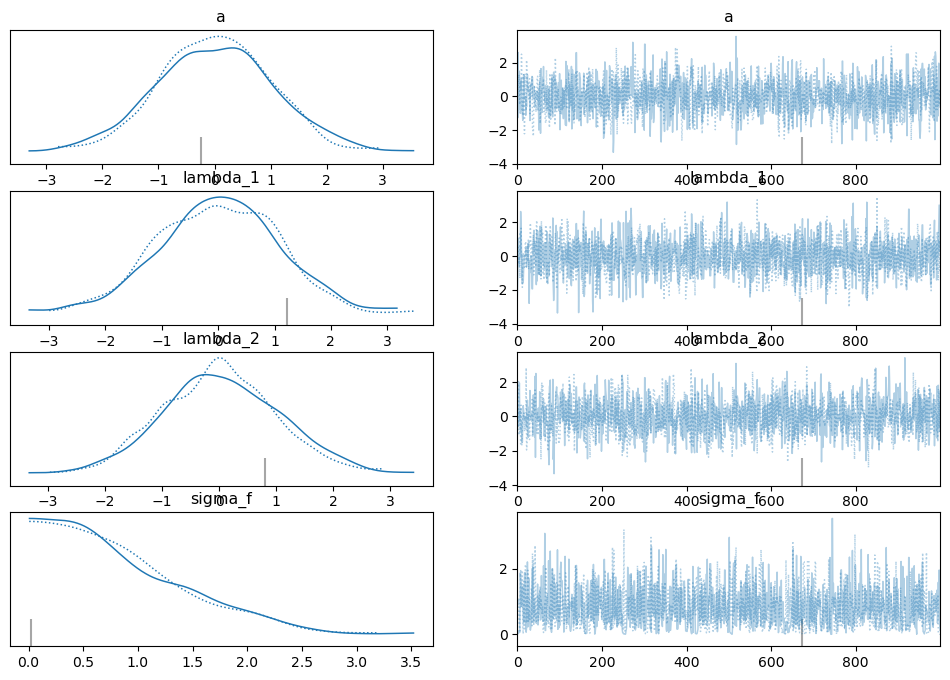

In [47]:
az.plot_trace(idata, var_names=["a", "lambda_1", "lambda_2", "sigma_f"])

array([<Axes: title={'center': 'a'}>,
       <Axes: title={'center': 'lambda_1'}>,
       <Axes: title={'center': 'lambda_2'}>,
       <Axes: title={'center': 'sigma_f'}>], dtype=object)

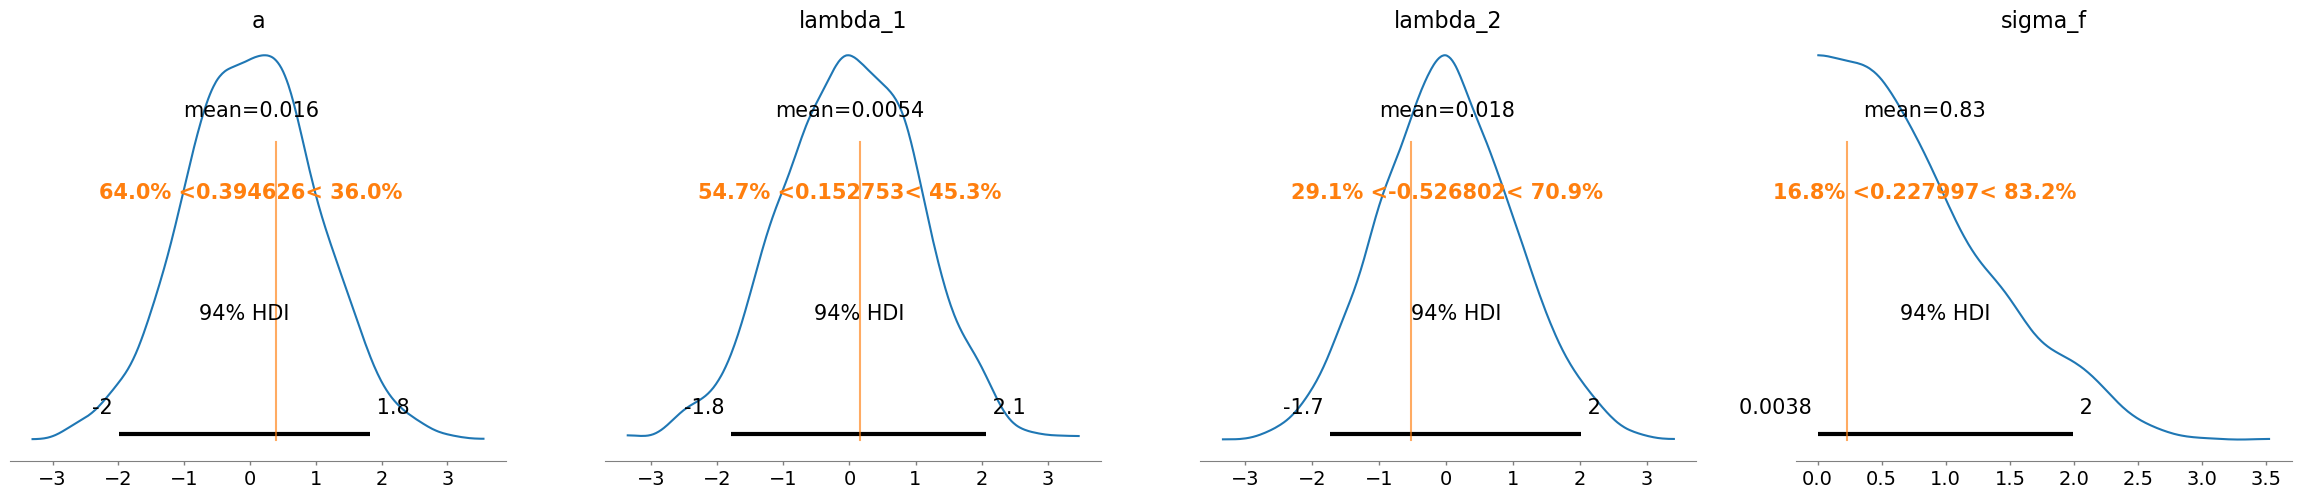

In [48]:
az.plot_posterior(
    idata,
    var_names=["a", "lambda_1", "lambda_2", "sigma_f"],
    ref_val=[true_a, true_lambda_1, true_lambda_2, true_sigma_f],
)